# Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import itstgcn_intro
import random
import plotly.express as px

# Data

# 한국남부발전(주)_한경풍력 일평균 풍속데이터

[출처](https://www.data.go.kr/data/15076402/fileData.do)

> 한국남부발전(주)_한경풍력 일평균 풍속데이터에 대한 데이터로 구분(년월일), 호기별 풍속데이터(1호-3호,5호-9기) 항목을 제공합니다. 해당 데이터의 단위는 m/s 입니다.

In [2]:
data1 = pd.read_csv('./data_example/한국남부발전(주)_한경풍력 일평균 풍속데이터_20240326.csv',encoding='CP949')
data1

구분  한경1호기  한경2호기  한경3호기  한경5호기  한경6호기  한경7호기  한경8호기  한경9호기
0     2018-01-01    7.7    7.9    7.4    6.5    8.2    7.5    7.8    8.8
1     2018-01-02    6.4    5.8    6.4    6.6    8.1    7.8    7.7    6.1
2     2018-01-03   10.2   10.9    9.9    9.6   11.9   11.7   11.3   12.6
3     2018-01-04    8.7    8.9    8.0    7.9    9.5    9.5    8.7    9.8
4     2018-01-05    9.3    9.4    9.1    7.4   10.2   10.4    8.8   10.6
...          ...    ...    ...    ...    ...    ...    ...    ...    ...
2271  2024-03-22    9.9   10.4    9.3   12.1   12.4   11.9   11.9   13.7
2272  2024-03-23    2.5    4.8    4.2    4.2    4.5    4.8    4.5    5.3
2273  2024-03-24    0.7    3.1    2.8    3.0    3.0    3.1    2.7    2.6
2274  2024-03-25    0.8    2.7    2.6    2.6    2.6    2.9    2.6    2.8
2275  2024-03-26    8.3    9.3    9.4    9.1    8.9    8.5    9.9    9.9

[2276 rows x 9 columns]

`-` 0

In [3]:
(data1==0).sum()

구분         0
한경1호기     17
한경2호기     49
한경3호기     11
한경5호기    751
한경6호기     11
한경7호기     11
한경8호기     11
한경9호기     11
dtype: int64

In [4]:
_node_ids = {
    'node0': '한경1호기',
    'node1': '한경2호기',
    'node2': '한경3호기',
    'node3': '한경5호기',
    'node4': '한경6호기',
    'node5': '한경7호기',
    'node6': '한경8호기',
    'node7': '한경9호기'
}

_FX1=[]
for i in [1,2,3,5,6,7,8,9]:
    _FX1.append(data1.iloc[:,1:][f'한경{i}호기'])
_FX1 = np.array(_FX1).reshape(-1,8).tolist()
    
edges = torch.tensor([[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7]]).tolist()

data_dict = {'edges':edges, 'node_ids':_node_ids, 'FX':_FX1}

node0 = data1.한경1호기
node1 = data1.한경2호기
node2 = data1.한경3호기
node3 = data1.한경5호기
node4 = data1.한경6호기
node5 = data1.한경7호기
node6 = data1.한경8호기
node7 = data1.한경9호기

In [5]:
data = pd.DataFrame({'node0':node0,'node1':node1,'node2':node2,'node3':node3,'node4':node4,'node5':node5,'node6':node6,'node7':node7})

In [6]:
loader = itstgcn_intro.DatasetLoader(data_dict)

In [7]:
nodes = len(data_dict['edges'])

In [8]:
T = len(data_dict['FX'])

In [9]:
lags=2

In [10]:
mindex=[random.sample(range(0, T), int(T*0.8)),[np.array(list(range(10,100)))],[],[],[],[],[]]
# mindex = []

In [11]:
mtype='block'

In [12]:
name = 'Proposed'

In [13]:
observed_values = []

In [14]:
for node in range(nodes+1):
        observed_values.append({
            f'node{node}': data[f'node{node}']
        })

In [15]:
dataset = loader.get_dataset(lags=2)

In [16]:
dataset_miss = itstgcn_intro.miss(dataset,mindex,mtype=mtype)

/home/csy/Dropbox/ITTGNN_blog/posts/2_research/itstgcn_intro/utils.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/torch/csrc/utils/tensor_new.cpp:245.)
  lags = torch.tensor(train_dataset.features).shape[-1]


In [17]:
dataset_padded = itstgcn_intro.padding(dataset_miss,interpolation_method='linear')

In [18]:
epochs = 10

In [19]:
filters = 16

In [20]:
if name == 'Classic' :
    lrnr = itstgcn_intro.StgcnLearner(dataset_padded)
elif name == 'Proposed' :
    lrnr = itstgcn_intro.ITStgcnLearner(dataset_padded)

In [21]:
lrnr.learn(filters, epochs)

In [22]:
dfs_by_node = {}

In [23]:
results=lrnr.result_dict

In [24]:
for node in range(0, nodes):
        df_node = pd.DataFrame()
        df_node[f'node{node}'] = observed_values[node][f'node{node}'][:-lags]
        df_node[f'node{node}_padding'] = torch.tensor(dataset_padded.targets).reshape(-1,nodes+1)[:,node]

        for epoch in range(epochs):
            epoch_key = f'epoch={epoch},node={node}'
            df_node[epoch_key] = [
                str(results[f'epoch={epoch},time={time_step}'].detach()[node]).replace("tensor(", "").strip().replace(")", "").strip()
                for time_step in range(0, T-lags)]

            if name == "Proposed" :
                df_node[f'epoch={epoch},node{node},trim'] = lrnr.trimed[f'epoch={epoch}'][:,node][:-lags]
                df_node[f'epoch={epoch},node{node},threshed'] = lrnr.threshed[f'epoch={epoch}'][:,node][:-lags]**2
                df_node[f'epoch={epoch},node{node},power'] = lrnr.power[f'epoch={epoch}'][:,node][:-lags]**2
            else:
                pass

        df_node = df_node.reset_index() 
        df_node.rename(columns={'index': 'Time'}, inplace=True)
        dfs_by_node[node] = df_node

In [25]:
df = dfs_by_node

In [26]:
melted_df = {}

In [27]:
for node in range(nodes):
    melted_table = df[node].melt(id_vars=['Time'], value_name='value', ignore_index=False)

    split_cols = melted_table['variable'].str.split(',', expand=True)
    melted_table = pd.concat([melted_table, split_cols], axis=1)

    melted_table = melted_table.rename(columns={0: 'first_part', 1: 'second_part', 2: 'third_part'})

    melted_table['value'] = pd.to_numeric(melted_table['value'], errors='coerce')

    melted_df[node] = melted_table

In [28]:
melted_rst = melted_df

In [29]:
figs = []

In [30]:
for node in range(nodes):

    if name == 'Classic': 
        filtered_df = melted_rst[node].query(f'first_part not in ["node{node}_missing", "node{node}_padding"]')

    if name == 'Proposed': 
        filtered_df = melted_rst[node].query(f'first_part not in ["node{node}_missing", "node{node}_padding"] and third_part not in ["trim","power","threshed"]')

        trim_df = melted_rst[node].query(f'third_part in ["trim"]')
        threshed_df = melted_rst[node].query(f'third_part in ["threshed"]')
        power_df = melted_rst[node].query(f'third_part in ["power"]')

        fig1 = px.line(trim_df, 
              x=trim_df['Time'], 
              y=trim_df['value'], 
              animation_frame=trim_df['first_part'],
              range_x=[0, T], 
              range_y=[np.min(trim_df['value'])-10, np.max(trim_df['value'])+10],
              width=2000, height=1200,
              title = "Trimed Vlues")

        fig1.layout['xaxis'].title = 'Time'
        fig1.layout['yaxis'].title = 'Values'

        fig2 = px.line(threshed_df, 
              x=threshed_df['Time'], 
              y=threshed_df['value'], 
              animation_frame=threshed_df['first_part'],
              range_x=[0, T], 
              range_y=[np.min(threshed_df['value'])-10, np.max(threshed_df['value'])+10 ],
              width=2000, height=1200,
              title = "Threshed Vlues")

        fig2.layout['xaxis'].title = 'Time'
        fig2.layout['yaxis'].title = 'Values'

        fig3 = px.line(power_df, 
              x=power_df['Time'], 
              y=power_df['value'], 
              animation_frame=power_df['first_part'],
              range_x=[0, T],
              range_y=[np.min(power_df['value'])-10, np.max(power_df['value'])+10],
              width=2000, height=1200,
              title = "Power")

        fig3.layout['xaxis'].title = 'Time'
        fig3.layout['yaxis'].title = 'Values'

        figs.append(fig1)
        figs.append(fig2)
        figs.append(fig3)


    fig4 = px.line(filtered_df, 
                  x=filtered_df['Time'], 
                  y=filtered_df['value'], 
                  animation_frame=filtered_df['first_part'],
                  range_x=[0, T], range_y=[np.min(filtered_df['value'])-10,np.max(filtered_df['value'])+10],
                  width=2000, height=1200,
                  title = f"yhat by each epoch on {node}")

    fig4.layout['sliders'][0]['currentvalue'] = {'prefix': ''}
    fig4.layout['xaxis'].title = 'Time'
    fig4.layout['yaxis'].title = 'Values'

    figs.append(fig4)

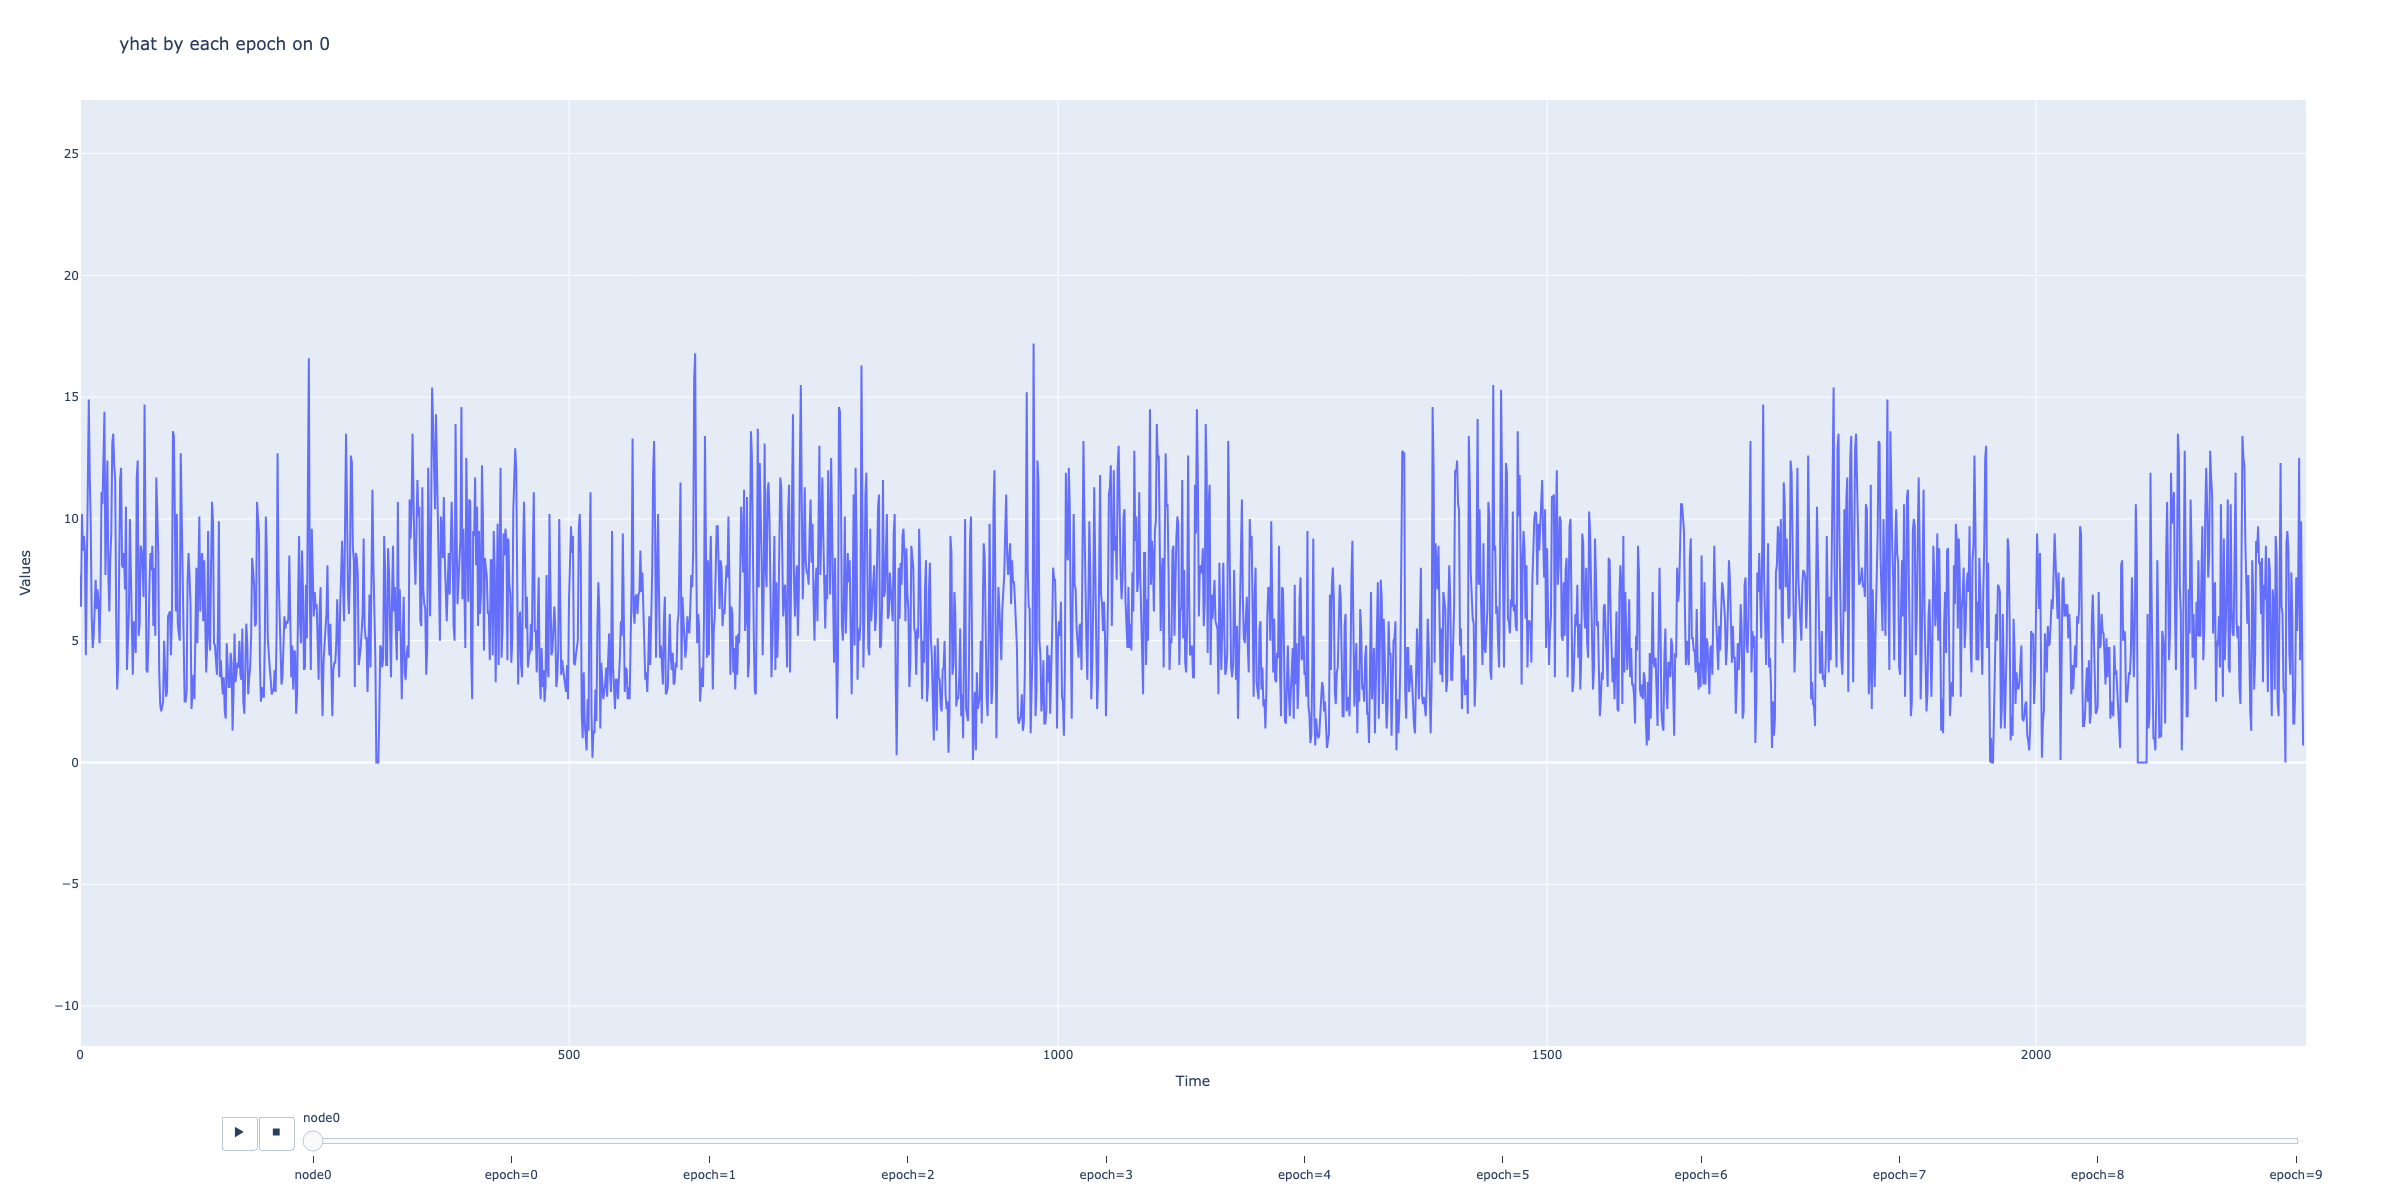

In [31]:
figs[3]